#  Daisyworld without radiative equilibrium

In this notebook we will review the modified Daisyworld model created by Nevson et. al (1999). These authors changed the original model in order to make it a little bit more realistic.The original Dasyworld model assumes that Daisywolrd is in a perfect radiative balance. This means that the incoming radiation to the planet is exactly equals to the outgoing radiation. However, this is an unrealistic assumption. As the authors of this paper say: the "Earth is well known to be in imperfect balance, both spatially and temporally, between incoming solar and outgoing longwave radiation".

In order to add this feature to the model, the authors replaced equation 4 of the original Daisywolrd notebook, with an ordinary differential equation that describes the chage in the effective temperature of the Earth. So the original equation 4 becomes:

\begin{equation} \tag{4}
c_p (\frac{dT_e}{dt}) = SL(1 - A) - \sigma {T_e}^4
\end{equation}

where $c_p$ ($ erg K^-1 cm^{-2}$) is a measure of the thermal inertia of the planet, $T_e (K)$ is the effective temperature, $S$ = $2.89x10^{13} erg year^{-1} cm^{-2}$ is the total radiation reaching the planet, L is a dimensionless number that controls the radiation of the sun, $\sigma =$ 1789 $erg K^{-4} cm^{-2} year^{-1}$ is Stefan-Boltzmann’s constant for blackbody radiation, and $A$ is the total albedo of the planet. It is important to note that the authors modified the units of some constants to measure time in years.

Let's solve this model to see how the introduction of the new equation affects the behavior of the daisies. For the most part we will be using the same code as in the original Daisywolrd model, introducing a few changes to account for the new equation.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

class Unbalanced_Daisywolrd():
    q = 2064250710.0 #20 # Heat Transfer Coefficient
    sigma = 1789  #Stefan-Boltzman Constant
    S = 2.89e+13  # Solar constant
    
    
    def __init__(self
                ,death_rate =.3 #death rate of daysies
                ,albedo_w=0.75  #white daysies albedo
                ,albedo_g=0.5  #Free ground albedo      
                ,albedo_b=0.25  #Black daysies albedo
                ,area_w= 0.3 # Fraction area of white daisies
                ,area_b= 0.3 # Fraction area of black daisies
                ,cp = 3e+13 # thermal inertia
                ,L = 1 # Solar luminosity constant
                ):
        'Initilize all the constants and variables'
        self.death_rate = death_rate
        self.albedo_w = albedo_w
        self.albedo_g = albedo_g
        self.albedo_b = albedo_b
        self.area_w = area_w
        self.area_b = area_b
        self.area_g = 1 - self.area_b - self.area_w # Equation 2
        self.cp = cp
        self.L = L
        self.albedo_total = self.area_w * self.albedo_w + self.area_b * self.albedo_b + self.area_g * self.albedo_g
        self.Te = ((self.S * self.L * (1- self.albedo_total) / self.sigma) ** 0.25)- 273 #Equation 4
        self.Tw = (self.q*(self.albedo_total - self.albedo_w) + (self.Te +273)**4 )**.25 -273
        self.Tb = (self.q*(self.albedo_total - self.albedo_b)+ (self.Te +273)**4 )**.25 -273
        self.Bw = 1 -0.003265 * ((22.5-self.Tw)**2) #Equation 2
        self.Bb = 1 -0.003265 * ((22.5-self.Tb)**2) #Equation 2
        
    def update_area_g(self):
        'Calclates area of free ground'
        self.area_g = 1 - self.area_b - self.area_w 
        return self.area_g
    
    def update_albedo_total(self):
        '''Calculates average albedo of Dasyworld'''
        self.albedo_total = self.area_w * self.albedo_w + self.area_b * self.albedo_b + self.area_g * self.albedo_g

    
    def update_global_temp(self, h):
        '''Solves greenhouse effect equation with Euler method'''
        self.Te += h * (self.S * self.L * (1- self.albedo_total) - self.sigma * (self.Te + 273)**4) / self.cp 

    
    def update_daisies_temp(self):
        self.Tw = (self.q*(self.albedo_total - self.albedo_w) + (self.Te +273)**4 )**.25 -273
        self.Tb = (self.q*(self.albedo_total - self.albedo_b)+ (self.Te +273)**4 )**.25 -273
        #Linear aproximation case (q = 20)
        #self.Tw = self.q*(self.albedo_total-self.albedo_w)+ self.Te 
        #self.Tb = self.q*(self.albedo_total-self.albedo_b)+ self.Te 
    
    def update_growth_rate(self):
        self.Bw = 1 -0.003265 * ((22.5-self.Tw)**2)
        self.Bb = 1 -0.003265 * ((22.5-self.Tb)**2)
    
    
    def solve_model(self, iterations = 12000, h = 0.1, store_values = False):
        'Solve equation 1 with euler method and recalculate all other variables'
        AW, AB, AG, TW, TB, TE = ([],[],[],[],[],[])
        for i in range(iterations):
            self.area_w += h * self.area_w * (self.Bw * self.area_g -self.death_rate)
            self.area_b += h * self.area_b * (self.Bb * self.area_g -self.death_rate)
            self.update_area_g()
            self.update_albedo_total()
            self.update_global_temp(h)
            self.update_daisies_temp()
            self.update_growth_rate()
            if store_values:
                AW.append(self.area_w)
                AB.append(self.area_b)
                AG.append(self.area_g)
                TW.append(self.Tw)
                TB.append(self.Tb)
                TE.append(self.Te) 
        if store_values:
            self.AW = AW
            self.AB = AB
            self.AG = AG
            self.TW = TW
            self.TB = TB
            self.TE = TE
    
    def plot_model(self, Tb=False, Tw= False):
        '''Makes a plot of the daises areas and of the global temperature with time'''
        time = (np.arange(0, len(self.AB)) / 10).tolist()
        plt.figure()
        plt.plot(time, self.AB, 'k', linewidth=2, label='Black')
        plt.plot(time, self.AW, 'g',linewidth=2,label='White')
        plt.xlabel('Time (years)', fontsize=15)
        plt.ylabel(r'Fraction area area_i', fontsize=15)
        plt.title('Change in daisies population', fontsize=17)
        legend = plt.legend(loc=1, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        
        plt.figure()
        if Tb:
            plt.plot(time, self.TB, 'k--', linewidth=2, label='Tb')
        if Tw:
            plt.plot(time, self.TW, 'k:', linewidth=2, label='Tw' )
        plt.plot(time, self.TE, 'k', linewidth=2, label='Te' )
        plt.xlabel('Time (years)', fontsize=15)
        plt.ylabel(r'Temperature (°C)', fontsize=15)
        plt.title('Change in Temperature', fontsize=18)
        legend = plt.legend(loc=1, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        
        
    
    def change_luminosity(self, L, iterations = 12000, h = 0.1):
        '''
        Change the sola luminosity in the model
        INPUT:
            self: Daisywolrd class
            L (lIST): list describing change in luminosity.
        '''
        #iteration parameters
        n = len(L)
        # lists to store values
        change_lum_TE, change_lum_AW, change_lum_AB, change_lum_AG = ([],[],[],[])
        # initial values
        area_w, area_b, albedo_w, albedo_b, albedo_g, death_rate =\
        self.area_w, self.area_b, self.albedo_w, self.albedo_b, self.albedo_g, self.death_rate
        for i in range(n):
            model = Unbalanced_Daisywolrd(area_w=area_w, area_b = area_b)
            model.L = L[i]
            model.solve_model(iterations, h)
            change_lum_AW.append(model.area_w)
            change_lum_AB.append(model.area_b)
            change_lum_AG.append(model.area_g)
            change_lum_TE.append(model.Te)
        self.change_lum_TE = np.array(change_lum_TE)
        self.change_lum_AW = np.array(change_lum_AW)
        self.change_lum_AB = np.array(change_lum_AB)
        self.change_lum_AG= np.array(change_lum_AG)
        self.L = L
        self.no_life_Te = (self.S * self.L * (1- 0.5) / self.sigma)**0.25-273
    
    def plot_change_luminosity(self):
        '''Makes plots of the change in solar luminosity'''
        plt.figure()
        plt.plot(self.L, self.change_lum_AB, 'k', linewidth=3, label='Black')
        plt.plot(self.L, self.change_lum_AW, 'g',linewidth=3,label='White')
        #plt.plot(self.L, self.change_lum_AB + self.change_lum_AW, 'k--', linewidth=3, label='Sum')
        plt.xlabel('Solar Luminosity $L$', fontsize=15)
        plt.ylabel(r'Fraction area area_i', fontsize=15)
        plt.title('Change in daisies population', fontsize=17)
        plt.axis([0.4, 1.8, -0.1, 0.8])
        legend = plt.legend(loc=1, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        # Set the fontsize
        for label in legend.get_texts():
            label.set_fontsize('large')
        for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
            
        plt.figure() 
        plt.plot(self.L, self.change_lum_TE, 'g', linewidth=3, label='T with daisies')
        plt.plot(self.L, self.no_life_Te , 'k--', linewidth=3, label='T without daisies')
        plt.xlabel('Solar Luminosity $L$', fontsize=15)
        plt.ylabel('$T $ [$^\circ C$]', fontsize=15)
        plt.title('Change in effective Temparetaure', fontsize=17)
        plt.axis([0.4, 1.6, -30, 70])
        legend = plt.legend(loc=4, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        # Set the fontsize
        for label in legend.get_texts():
            label.set_fontsize('large')
        for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
        plt.show()
            

        

Now that we have a class to solve the model, let's find out how the daisies behave in a world without radiative equilibrium. First let's see how the populations and the temperature behave.

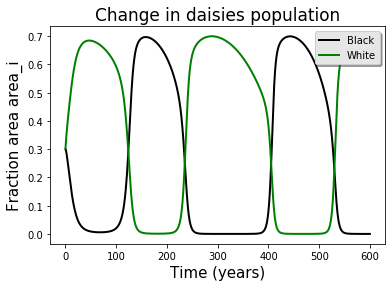

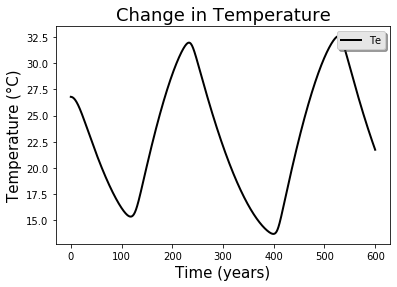

In [10]:
model = Unbalanced_Daisywolrd(L=1)
model.solve_model(store_values = True, iterations = 6000)
model.plot_model()

The first thing to notice is that without radiative equilibrium, the populations of daisies present oscillations in time that are closely related to oscillations in the effective temperature. In contrast, in the original model the populations and the effective temperature achieve a stable equilibrium after some time.

When the temperature decreases the conditions are favorable for black daisies, and when the temperature augments the conditions are favorable for white daisies. In turn, when the white daisies increase their population, the effective temperature tends to decrease, and when the black daisies increase their population, the effective temperature augments. In this way, it is the interaction between the daisies and the environment that creates the oscillations. It is interesting to note that the oscillations are not maintained when there is only one kind of daisy in Daisywolrd. In the next figure we see that the population and the temperatures reach an equilibrium after some time.

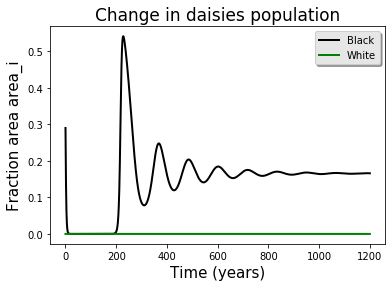

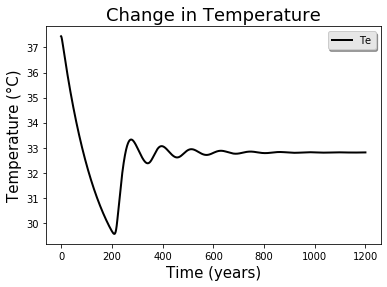

In [11]:
model = Unbalanced_Daisywolrd(area_w=0)
model.solve_model(store_values = True, iterations = 12000)
model.plot_model()

The oscillations are also influenced by the death rate of daisies. For example, as we see in the following figure, with a very small death rate the oscillations disappear.

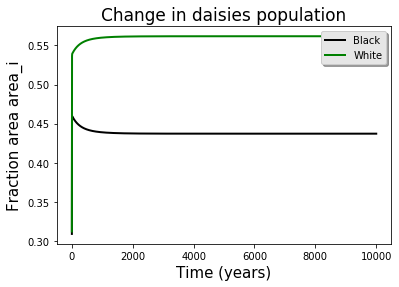

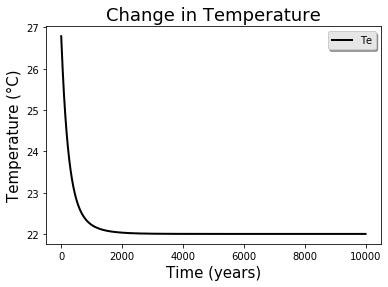

In [12]:
model = Unbalanced_Daisywolrd(death_rate=0.001)
model.solve_model(store_values = True, iterations = 100000)
model.plot_model()

Also, the period of the oscillations varies with the thermal inertia of the planet in a certain range. For instance, in the following figure we see that for a thermal inertia of $6x10^{12}$ the period of the oscillation decreases.

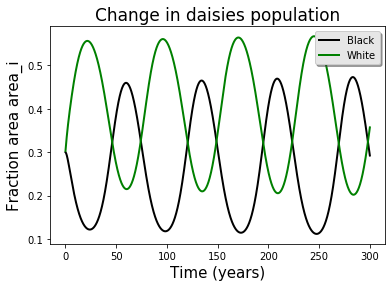

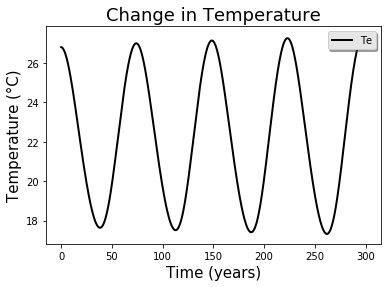

In [14]:
model = Unbalanced_Daisywolrd(cp = 6e12)
model.solve_model(store_values = True, iterations = 3000)
model.plot_model()

The solar luminosity can also affect the oscillations. You can check this varying L in the Unbalanced_Daisywolrd class. However, it is important to see if this model also shows a self-regulation of the effective temperature despite external forcing agents. As we see in the following image, if we change the luminosity in the unbalanced Daisywolrd, and run the model for 12000 years at each luminosity, the results are quite chaotic. The populations present drastic oscillations, and the effective temperature does not present the zone of stability present in the original model. We could be tempted conclude that the the Daisywolrd without radiative equilibrium does not present self-regulation, but this would be misleading. The problem is that the populations of daisies oscillate with time, so if we run the model for 1000 years we would obtain a different result than if we run the model for 12000 years.

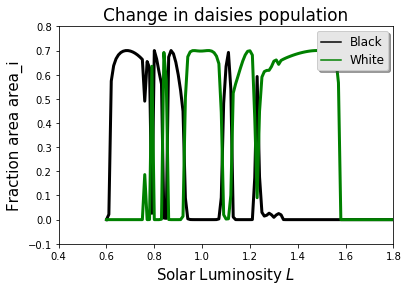

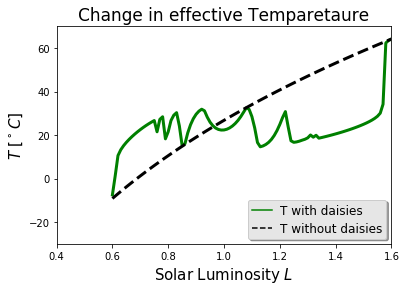

In [17]:
L = np.arange(0.6, 1.8, 0.01)
model1 = Unbalanced_Daisywolrd()
model1.change_luminosity(L, iterations=12000)
model1.plot_change_luminosity()


To cope with this problem we can run the model for different times at the same luminosity, taking the average temperature and the average of the population areas. We can see the code and result of this process in the following cell. In the first figure we see the average area of white and black daisies. The behavior is strikingly similar to the one of the original Daisywolrd
model. In the second figure we see the min, max and average effective temperature of the planet. This variables show a zone of stability where the temperature does not change much despite the increasing luminosity. We can now conclude that the Daisyworld without radiative equilibrium still is a self-regulated system.

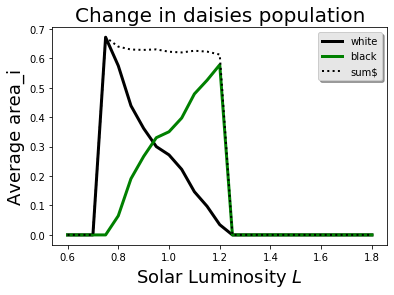

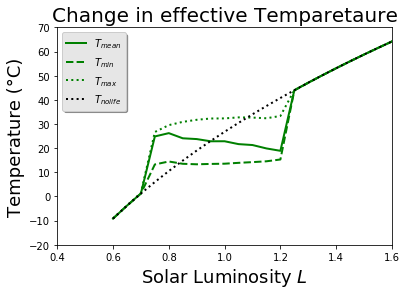

In [10]:
iterations = np.arange(1000, 12000, 200)
L = np.arange(0.6, 1.8, 0.05)
#effective temperature without life
no_life_Te = (2.89e+13 * L * (1- 0.5) / 1789)**0.25-273
#lists to store values
Te_min = []
Te_max = []
Te_mean = []
area_b_mean = []
area_w_mean = []
#for each luminosity value
for value in L:
    Te = []
    ab = []
    aw = []
    #run the model for different times
    for iteration in iterations:
        model = Unbalanced_Daisywolrd(L = value)
        model.solve_model( iterations = iteration)
        Te.append(model.Te)
        ab.append(model.area_b)
        aw.append(model.area_w)
    #Calculate average, min and max of variables
    Te_min.append(np.array(Te).min())
    Te_max.append(np.array(Te).max())
    Te_mean.append(np.array(Te).mean())  
    area_b_mean.append(np.array(ab).mean())
    area_w_mean.append(np.array(aw).mean())

#Make plots
plt.figure()
plt.plot(L, area_b_mean, 'k', linewidth=3, label='white')
plt.plot(L, area_w_mean, 'g',linewidth=3, label='black')
plt.plot(L, np.array(area_b_mean) + np.array(area_w_mean), 'k:' ,linewidth=2, label='sum$')
plt.xlabel('Solar Luminosity $L$', fontsize=18)
plt.ylabel('Average area_i', fontsize=18)
plt.title('Change in daisies population', fontsize=20)
legend = plt.legend(loc=0, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
   
plt.figure()
plt.plot(L, Te_mean, 'g', linewidth=2, label='$T_{mean}$')
plt.plot(L, Te_min, 'g--',linewidth=2, label='$T_{min}$')
plt.plot(L, Te_max, 'g:' ,linewidth=2, label='$T_{max}$')
plt.plot(L, no_life_Te, 'k:' ,linewidth=2, label='$T_{nolife}$')
plt.xlabel('Solar Luminosity $L$', fontsize=18)
plt.ylabel('Temperature (°C)', fontsize=18)
plt.title('Change in effective Temparetaure', fontsize=20)
plt.axis([0.4, 1.6, -20, 70])
legend = plt.legend(loc=0, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')



# References

* Nevison C, Gupta V., and Klinger L. *Self-sustained temperature oscillations on Daisyworld*. Tellus 51B, 806–814.